In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

from ast import literal_eval

from urllib.parse import urlparse

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import string
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer as PS

import joblib


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# data = pd.read_csv('dataset/full_dataset.csv')
data = pd.read_csv('../work/dataset/full_dataset.csv')

In [3]:
data.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2231142 entries, 0 to 2231141
Data columns (total 7 columns):
 #   Column       Dtype 
---  ------       ----- 
 0   Unnamed: 0   int64 
 1   title        object
 2   ingredients  object
 3   directions   object
 4   link         object
 5   source       object
 6   NER          object
dtypes: int64(1), object(6)
memory usage: 119.2+ MB


In [5]:
data.ingredients[0]

'["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]'

In [6]:
data.directions[0]

'["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]'

In [7]:
data.NER[0]

'["brown sugar", "milk", "vanilla", "nuts", "butter", "bite size shredded rice biscuits"]'

In [8]:
data.source.unique()

array(['Gathered', 'Recipes1M'], dtype=object)

In [9]:
data = data.loc[data['source'] == 'Gathered']

In [10]:
data.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [11]:
data.source.unique()

array(['Gathered'], dtype=object)

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1643098 entries, 0 to 1643097
Data columns (total 7 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   Unnamed: 0   1643098 non-null  int64 
 1   title        1643098 non-null  object
 2   ingredients  1643098 non-null  object
 3   directions   1643098 non-null  object
 4   link         1643098 non-null  object
 5   source       1643098 non-null  object
 6   NER          1643098 non-null  object
dtypes: int64(1), object(6)
memory usage: 100.3+ MB


In [13]:
toy_data = data.iloc[:5]
toy_data

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [14]:
toy_data = toy_data[['title','source']]
toy_data

,title,source
0,No-Bake Nut Cookies,Gathered
1,Jewell Ball'S Chicken,Gathered
2,Creamy Corn,Gathered
3,Chicken Funny,Gathered
4,Reeses Cups(Candy),Gathered


In [15]:
G = nx.Graph()

In [16]:
G = nx.from_pandas_edgelist(toy_data, 'title', 'source')

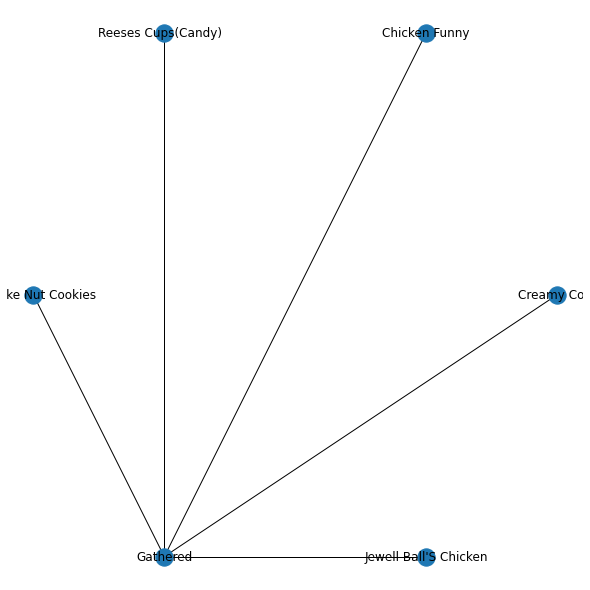

In [17]:
plt.figure(figsize=(8,8))
nx.draw_shell(G, with_labels=True)

In [18]:
def literal_return(val):
    try:
        return literal_eval(val)
    except (ValueError, SyntaxError) as e:
        return val

def df_str_to_literal(df, column_name):
    df[column_name] = df[column_name].apply(literal_return)
    return df[column_name]

In [19]:
toy_data = data.sample(frac=0.5, replace=False)
toy_data.head(10)

,Unnamed: 0,title,ingredients,directions,link,source,NER
415903,415903,Italian Baked Chicken,"[""boneless chicken breast filets"", ""mayonnaise...","[""Cover each filet with mayonnaise and roll in...",www.cookbooks.com/Recipe-Details.aspx?id=677554,Gathered,"[""chicken breast filets"", ""mayonnaise"", ""Itali..."
1374307,1374307,Grandma Joan'S Marshmallow Brownies,"[""For the brownies:"", ""4 squares (4 ounces) un...","[""Grease a 9- by 13-inch baking pan and heat t...",food52.com/recipes/68173-grandma-joan-s-marshm...,Gathered,"[""brownies"", ""squares"", ""butter"", ""eggs"", ""sug..."
851366,851366,Kraut Salad,"[""1 (1 lb.) can sauerkraut, rinsed and drained...","[""Mix well and chill overnight.""]",www.cookbooks.com/Recipe-Details.aspx?id=812727,Gathered,"[""sauerkraut"", ""sugar"", ""white vinegar"", ""cele..."
41573,41573,Broccoli And Rice Casserole,"[""1 c. raw Minute rice"", ""2 pkg. frozen, chopp...","[""Heat oven to 350\u00b0."", ""Combine ingredien...",www.cookbooks.com/Recipe-Details.aspx?id=259462,Gathered,"[""rice"", ""frozen"", ""butter"", ""onion"", ""milk"", ..."
365261,365261,Lasagne,"[""1 clove garlic, minced"", ""1 medium onion, ch...","[""Saute garlic and onion in small amount of fa...",www.cookbooks.com/Recipe-Details.aspx?id=560613,Gathered,"[""clove garlic"", ""onion"", ""lean ground beef"", ..."
1053461,1053461,Chicken And Noodles (Crock Pot),"[""3 -4 lbs chicken pieces (I use 4 chicken bre...","[""Put all ingredients, except noodles, in croc...",www.food.com/recipe/chicken-and-noodles-crock-...,Gathered,"[""chicken"", ""chicken broth"", ""butter"", ""conden..."
1445130,1445130,Citrus-Glazed Chicken Thighs,"[""1 cup orange juice"", ""2 tablespoons low-sodi...","[""Place first 7 ingredients in a large zip-top...",www.myrecipes.com/recipe/citrus-glazed-chicken...,Gathered,"[""orange juice"", ""soy sauce"", ""honey"", ""garlic..."
1512788,1512788,Mousse In A Minute,"[""1-1/2 cups whipped topping"", ""1 can (15-3/4 ...","[""In a bowl, fold whipped topping into pie fil...",www.tasteofhome.com/recipes/mousse-in-a-minute/,Gathered,"[""topping"", ""lemon pie filling"", ""graham crack..."
642249,642249,"Cocoa ""Melt-In-Your-Mouth"" Cookie-Press Cookies","[""1 c. butter or margarine"", ""2/3 c. sugar"", ""...","[""Cream butter, sugar,"", ""egg"", ""and\tvanilla""...",www.cookbooks.com/Recipe-Details.aspx?id=325318,Gathered,"[""butter"", ""sugar"", ""egg"", ""vanilla"", ""flour"",..."
1377467,1377467,Guilt-Free Creamy Greek Yogurt Avocado Dip,"[""1 avocado"", ""7 ounces fat free Fage Greek yo...","[""In a blender or food processor blend avocado...",food52.com/recipes/33997-guilt-free-creamy-gre...,Gathered,"[""avocado"", ""Greek yogurt"", ""lime"", ""Salt"", ""P..."


In [20]:
# toy_data.ingredients[1597583]

In [21]:
def clean_df(df, columns_list):
    for col in columns_list:
        df[col] = df_str_to_literal(df, col)
    return None

In [22]:
clean_df(toy_data, ['ingredients', 'directions', 'NER'])

In [23]:
toy_data.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER
415903,415903,Italian Baked Chicken,"[boneless chicken breast filets, mayonnaise, I...",[Cover each filet with mayonnaise and roll in ...,www.cookbooks.com/Recipe-Details.aspx?id=677554,Gathered,"[chicken breast filets, mayonnaise, Italian br..."
1374307,1374307,Grandma Joan'S Marshmallow Brownies,"[For the brownies:, 4 squares (4 ounces) unswe...",[Grease a 9- by 13-inch baking pan and heat th...,food52.com/recipes/68173-grandma-joan-s-marshm...,Gathered,"[brownies, squares, butter, eggs, sugar, vanil..."
851366,851366,Kraut Salad,"[1 (1 lb.) can sauerkraut, rinsed and drained,...",[Mix well and chill overnight.],www.cookbooks.com/Recipe-Details.aspx?id=812727,Gathered,"[sauerkraut, sugar, white vinegar, celery, oni..."
41573,41573,Broccoli And Rice Casserole,"[1 c. raw Minute rice, 2 pkg. frozen, chopped ...","[Heat oven to 350°., Combine ingredients and b...",www.cookbooks.com/Recipe-Details.aspx?id=259462,Gathered,"[rice, frozen, butter, onion, milk, cream of c..."
365261,365261,Lasagne,"[1 clove garlic, minced, 1 medium onion, chopp...",[Saute garlic and onion in small amount of fat...,www.cookbooks.com/Recipe-Details.aspx?id=560613,Gathered,"[clove garlic, onion, lean ground beef, tomato..."


In [24]:
# toy_data.ingredients[1597583]

In [25]:
# toy_data.directions[1597583]

In [26]:
# toy_data.NER[1597583]

In [27]:
# toy_data.link[1597583]

In [28]:
# path = urlparse(toy_data.link[0]).path
# path

In [29]:
# site = path.split('/')[0]
# site

In [30]:
def parse_link(link):
    path = urlparse(link).path
    site = path.split('/')[0]
    return site

def df_link_to_site(df, column_name, new_column_name):
    df[new_column_name] = df[column_name].apply(parse_link)
    return df[new_column_name]

In [31]:
# toy_data['site'] = df_link_to_site(toy_data, 'link', 'site')
# toy_data.head()

In [32]:
toy_data['bag_of_words'] = ''
columns_list = ['title', 'ingredients', 'directions']
for col in columns_list:
    if col == 'title':
        toy_data['bag_of_words'] += toy_data[col] + ' '
    #elif col != 'site':
        #toy_data['bag_of_words'] += toy_data[col].apply(' '.join) + ' '
    if col == 'ingredients':
        toy_data['bag_of_words'] += toy_data[col].apply(' '.join) + ' '
    if col == 'directions':
        toy_data['bag_of_words'] += toy_data[col].apply(' '.join)
#     if col == 'NER':
#         toy_data['bag_of_words'] += toy_data[col].apply(' '.join)
toy_data.head()

,Unnamed: 0,title,ingredients,directions,link,source,NER,bag_of_words
415903,415903,Italian Baked Chicken,"[boneless chicken breast filets, mayonnaise, I...",[Cover each filet with mayonnaise and roll in ...,www.cookbooks.com/Recipe-Details.aspx?id=677554,Gathered,"[chicken breast filets, mayonnaise, Italian br...",Italian Baked Chicken boneless chicken breast ...
1374307,1374307,Grandma Joan'S Marshmallow Brownies,"[For the brownies:, 4 squares (4 ounces) unswe...",[Grease a 9- by 13-inch baking pan and heat th...,food52.com/recipes/68173-grandma-joan-s-marshm...,Gathered,"[brownies, squares, butter, eggs, sugar, vanil...",Grandma Joan'S Marshmallow Brownies For the br...
851366,851366,Kraut Salad,"[1 (1 lb.) can sauerkraut, rinsed and drained,...",[Mix well and chill overnight.],www.cookbooks.com/Recipe-Details.aspx?id=812727,Gathered,"[sauerkraut, sugar, white vinegar, celery, oni...","Kraut Salad 1 (1 lb.) can sauerkraut, rinsed a..."
41573,41573,Broccoli And Rice Casserole,"[1 c. raw Minute rice, 2 pkg. frozen, chopped ...","[Heat oven to 350°., Combine ingredients and b...",www.cookbooks.com/Recipe-Details.aspx?id=259462,Gathered,"[rice, frozen, butter, onion, milk, cream of c...",Broccoli And Rice Casserole 1 c. raw Minute ri...
365261,365261,Lasagne,"[1 clove garlic, minced, 1 medium onion, chopp...",[Saute garlic and onion in small amount of fat...,www.cookbooks.com/Recipe-Details.aspx?id=560613,Gathered,"[clove garlic, onion, lean ground beef, tomato...","Lasagne 1 clove garlic, minced 1 medium onion,..."


In [33]:
# toy_data['bag_of_words'][1597583]

In [34]:
bow_toy_data = toy_data[['title','bag_of_words']]
bow_toy_data.head()

,title,bag_of_words
415903,Italian Baked Chicken,Italian Baked Chicken boneless chicken breast ...
1374307,Grandma Joan'S Marshmallow Brownies,Grandma Joan'S Marshmallow Brownies For the br...
851366,Kraut Salad,"Kraut Salad 1 (1 lb.) can sauerkraut, rinsed a..."
41573,Broccoli And Rice Casserole,Broccoli And Rice Casserole 1 c. raw Minute ri...
365261,Lasagne,"Lasagne 1 clove garlic, minced 1 medium onion,..."


In [35]:
documents = bow_toy_data.bag_of_words
documents

415903     Italian Baked Chicken boneless chicken breast ...
1374307    Grandma Joan'S Marshmallow Brownies For the br...
851366     Kraut Salad 1 (1 lb.) can sauerkraut, rinsed a...
41573      Broccoli And Rice Casserole 1 c. raw Minute ri...
365261     Lasagne 1 clove garlic, minced 1 medium onion,...
                                 ...                        
381742     Broccoli Supreme Casserole 2 pkg. frozen, chop...
1275259    Chicken Fajitas  4 skinless and boneless chick...
351123     Sweet And Sour Pork Chops 4 to 6 pork chops sa...
273188     Lasagne 1 1/2 lb. ground beef 2 Tbsp. garlic, ...
149530     Pasta And Bean Soup 2 slices bacon 1 small oni...
Name: bag_of_words, Length: 821549, dtype: object

In [36]:
# toy_doc = documents[1597583]
# toy_doc

In [37]:
# toy_doc_lower = toy_doc.lower()

In [38]:
# tokens = word_tokenize(toy_doc_lower)
# tokens[:30]

In [39]:
# punc = set(string.punctuation)
# tokens_no_punc = [word for word in tokens if word not in punc]
# tokens_no_punc[:30]

In [40]:
# s_words = set(stopwords.words('english'))
# tokens_no_sw = [word for word in tokens_no_punc if word not in s_words]
# tokens_no_sw[:30]

In [41]:
# porter = PS()
# tokens_stemmed = [porter.stem(word) for word in tokens_no_sw]
# tokens_stemmed[:30]

In [42]:
# cleaned_doc = ' '.join(tokens_stemmed)
# cleaned_doc

In [43]:
def clean_document(document):
    '''
    Takes in a string.
    Returns cleaned string.
    '''
    # lowercase the strings
    doc_lower = document.lower() 

    #tokenize
    tokens = word_tokenize(doc_lower) 
    
    # remove punctuation
    punc = set(string.punctuation)
    tokens_no_punc = [word for word in tokens if word not in punc]
   
    # remove stopwords
    s_words = set(stopwords.words('english'))
    s_words_list = ['tablespoon', 'tbsp', 'teaspoon', 'tsp', 'cup', 'oz', 'lb', 'c.']
    for word in s_words_list:
        s_words.add(word)
    tokens_no_sw = [word for word in tokens_no_punc if word not in s_words]
    
    # stem the words to get rid of multiple forms of the same word
    porter = PS()
    tokens_stemmed = [porter.stem(word) for word in tokens_no_sw]
    
    # join all words into one string
    cleaned_doc = ' '.join(tokens_stemmed)
    
    return cleaned_doc

In [44]:
bow_toy_data['cleaned_bow'] = toy_data['bag_of_words'].apply(clean_document)
bow_toy_data

<ipython-input-44-c02e925e9c02>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bow_toy_data['cleaned_bow'] = toy_data['bag_of_words'].apply(clean_document)


,title,bag_of_words,cleaned_bow
415903,Italian Baked Chicken,Italian Baked Chicken boneless chicken breast ...,italian bake chicken boneless chicken breast f...
1374307,Grandma Joan'S Marshmallow Brownies,Grandma Joan'S Marshmallow Brownies For the br...,grandma joan 's marshmallow browni browni 4 sq...
851366,Kraut Salad,"Kraut Salad 1 (1 lb.) can sauerkraut, rinsed a...",kraut salad 1 1 sauerkraut rins drain 1 1/2 su...
41573,Broccoli And Rice Casserole,Broccoli And Rice Casserole 1 c. raw Minute ri...,broccoli rice casserol 1 raw minut rice 2 pkg ...
365261,Lasagne,"Lasagne 1 clove garlic, minced 1 medium onion,...",lasagn 1 clove garlic minc 1 medium onion chop...
...,...,...,...
381742,Broccoli Supreme Casserole,"Broccoli Supreme Casserole 2 pkg. frozen, chop...",broccoli suprem casserol 2 pkg frozen chop bro...
1275259,Chicken Fajitas,Chicken Fajitas 4 skinless and boneless chick...,chicken fajita 4 skinless boneless chicken-bre...
351123,Sweet And Sour Pork Chops,Sweet And Sour Pork Chops 4 to 6 pork chops sa...,sweet sour pork chop 4 6 pork chop salt pepper...
273188,Lasagne,"Lasagne 1 1/2 lb. ground beef 2 Tbsp. garlic, ...",lasagn 1 1/2 ground beef 2 garlic chop 1 onion...


In [45]:
docs_cleaned = bow_toy_data['cleaned_bow']

In [46]:
num_features = 500
ngram_range=(1,2)

vec = CountVectorizer(max_df=0.85, 
                      min_df=2,
                      ngram_range=ngram_range,
                      max_features=num_features)

tf = vec.fit_transform(docs_cleaned)

In [47]:
tf_feature_names = vec.get_feature_names()
len(tf_feature_names)

500

In [48]:
num_topics = 100

lda = LatentDirichletAllocation(n_components=num_topics,
                                learning_method='online',
                                learning_offset=50,
                                doc_topic_prior=0.9,
                                topic_word_prior=0.9,
                                batch_size=32,
                                n_jobs=-1)
lda.fit(tf)

LatentDirichletAllocation(batch_size=32, doc_topic_prior=0.9,
                          learning_method='online', learning_offset=50,
                          n_components=100, n_jobs=-1, topic_word_prior=0.9)

In [49]:
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i]
                        for i in topic.argsort()[:-num_top_words - 1:-1]]))

# num_top_words = 30
# display_topics(lda, tf_feature_names, num_top_words)

In [50]:
# toy_data['bag_of_words'] = toy_data['NER'].apply(' '.join) + ' '
# toy_data.head()

In [51]:
# bow_toy_data = toy_data[['title','bag_of_words']]
# bow_toy_data.head()

In [52]:
# docs = bow_toy_data['bag_of_words']

In [53]:
# num_features = None
# ngram_range=(1,1)

# vec = CountVectorizer(max_df=0.85, 
#                       min_df=2,
#                       ngram_range=ngram_range,
#                       max_features=num_features)

# tf = vec.fit_transform(docs)

In [54]:
# tf_feature_names = vec.get_feature_names()
# len(tf_feature_names)

In [55]:
# num_topics = 10

# lda = LatentDirichletAllocation(n_components=num_topics,
#                                 learning_method='online',
#                                 random_state=0,
#                                 n_jobs=-1)
# lda.fit(tf)

In [56]:
# num_top_words = 15
# display_topics(lda, tf_feature_names, num_top_words)

In [57]:
joblib.dump(lda, 'lda_model_6_tid.joblib')
joblib.dump(vec, 'vec_6_tid.joblib')
lda = joblib.load('lda_model_6_tid.joblib')
tf_vectorizer = joblib.load('vec_6_tid.joblib')

In [58]:
lda.perplexity(tf)

257.09245845513874

In [59]:
lda.score(tf)

-304230141.72516316

In [60]:
probs = lda.transform(tf)

In [61]:
# probs[:5]

In [62]:
# cos_dists = cosine_distances(probs)

In [63]:
# keyword = 'bean'
# recipes = bow_toy_data.title
# idx_arr = np.array(recipes.index)
# keyword_recipes = recipes[recipes.str.contains(keyword, case=False, regex=False)]
# recipe_idx = recipes[recipes.str.contains(keyword, case=False, regex=False)].index[0]
# keyword_idx = int(np.where(idx_arr == recipe_idx)[0])
# keyword_idx

In [64]:
# recipes.loc[recipes.index[keyword_idx]]

In [65]:
# recipes.str.contains(keyword, case=False, regex=False)

In [66]:
# cos_dist = cosine_distances(probs[keyword_idx].reshape(1, -1), probs)

In [67]:
# sorted_sims = cos_dist.argsort()[::-1]
# sorted_sims #most similar to least similar articles

In [68]:
# #top ten closest articles:
# np.array(recipes)[sorted_sims[:, 1:11]]

In [69]:
def closest_recipes(keyword, recipes, probs, n_recipes=10):
    idx_arr = np.array(recipes.index)
    keyword_recipes = recipes[recipes.str.contains(keyword, case=False, regex=False)]
    keyword_samples = np.random.choice(keyword_recipes.index, size=1000, replace=True)
    keyword_idxs = []
    for sample_idx in keyword_samples:
        keyword_idx = int(np.where(idx_arr == sample_idx)[0])
        keyword_idxs.append(keyword_idx)

    d={}
    for idx in keyword_idxs:
        sims = cosine_distances(probs[idx].reshape(1, -1), probs).argsort()[0]
        for sim in sims[1:n_recipes+1]:
            if sim not in d:
                d[sim] = 1
            else:
                d[sim] += 1
                
    d_sorted = [k for k, v in sorted(d.items(), key=lambda item: item[1])][:-n_recipes:-1]
    print(f'Top {n_recipes} recipes most closely related to {keyword}')
    return np.array(recipes)[d_sorted]

In [70]:
# def closest_recipes(keyword, recipes, probs, n_docs=10):
#     recipe_idx = recipes[recipes.str.contains(keyword, case=False, regex=False)].index[0]
#     keyword_idx = int(np.where(idx_arr == recipe_idx)[0])
#     sims = cosine_distances(probs[keyword_idx].reshape(1, -1), probs).argsort()[0]
#     print(f'Top {n_docs} recipes most closely related to {keyword} (reference recipe: {recipes.loc[recipes.index[keyword_idx]]})')
#     return np.array(recipes)[sims[1:n_docs+1]]

In [72]:
recipes = bow_toy_data.title

In [73]:
closest_recipes('bean', recipes, probs)

Top 10 recipes most closely related to bean


array(['3 Bean Salad', 'Green Bean Casserole',
       '"Jack\'S" Crock-Pot Beans', 'Baked Bean Casserole',
       'Green Beans Creole', 'Green Beans & Whole Grain Mustard',
       'Settler Beans', 'Quick And Easy Cheese Bean Dip', 'Bean Hot Dish'],
      dtype=object)

In [74]:
closest_recipes('vegan', recipes, probs)

Top 10 recipes most closely related to vegan


array(['Raisin And Tamarind Chutney', 'Whole-Grain Pancakes',
       'Vanilla Icing', 'Yummy Blackberry Breakfast Smoothies',
       'Cheese Sauce Substitute', 'Plain Donuts', 'Anise Hyssop Cookies',
       'Luscious Lemon Cookies (Raw Foods)', 'Homemade Mixed Nut Butter'],
      dtype=object)

In [75]:
closest_recipes('pepperoni pizza', recipes, probs)

Top 10 recipes most closely related to pepperoni pizza


array(['Pepperoni Pizza Dip', 'Pepperoni Pizza Dip',
       'Pepperoni Pizza Dip', 'Pepperoni Pizza Dip',
       'Pepperoni Pizza Dip', 'Pepperoni Pizza Dip',
       'Pepperoni Pizza Dip', 'Pizza Dip', 'Pepperoni Pizza Dip'],
      dtype=object)

In [76]:
closest_recipes('spaghetti', recipes, probs)

Top 10 recipes most closely related to spaghetti


array(['Spaghetti Sauce', 'Spaghetti Sauce With Meat', 'Spaghetti Sauce',
       "Janet'S Spaghetti", 'Chicken Rotel', 'Spaghetti Salad',
       'Chicken Spaghetti', 'Goulash', 'Spaghetti Sauce'], dtype=object)

In [77]:
closest_recipes('chicken soup', recipes, probs)

Top 10 recipes most closely related to chicken soup


array(['Chicken Soup', 'Chicken Soup Broth ',
       'Chicken And Dumplings(4 Servings)  ', 'Prairie Chicken Soup',
       'Chicken Soup', 'Crouton Soup', 'Homemade Chicken Soup',
       "Granny'S Chicken Soup", 'Eggie Soup'], dtype=object)

Need to experiment with different parameters with the model, as well as the bag of words contents. First, let's see if we can identify the "best" number of topics using KMeans clustering.

In [ ]:
vectorizer = TfidfVectorizer(max_features=1000)
docs_vec = vectorizer.fit_transform(docs_cleaned)
features = vectorizer.get_feature_names()

In [ ]:
k=100
kmeans = KMeans(n_clusters=k)
kmeans.fit(docs_vec)
score = silhouette_score(docs_vec, kmeans.labels_)
print(f'k = {k}, silhouette score = {score}')

In [ ]:
# ks = [k for k in range(10, 101, 10)]
# scores = []
# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(docs_vec)
#     score = silhouette_score(docs_vec, kmeans.labels_)
#     scores.append(score)
#     print(f'k = {k}, silhouette score = {score}')

Doesn't seem like going above 100 clusters does much to improve the score. k = 100, score = 0.0452

In [ ]:
# ks = [k for k in range(110, 301, 10)]
# scores = []
# for k in ks:
#     kmeans = KMeans(n_clusters=k)
#     kmeans.fit(docs_vec)
#     score = silhouette_score(docs_vec, kmeans.labels_)
#     scores.append(score)
#     print(f'k = {k}, silhouette score = {score}')

In [ ]:
# Find the top 10 features for each cluster.
n_features = 10
top_centroids = kmeans.cluster_centers_.argsort()[:,-1:-(n_features+1):-1]
print("top features (words) for each cluster:")
for num, centroid in enumerate(top_centroids):
    print(f"{num}, {', '.join(features[i] for i in centroid)}")

In [ ]:
print("Random sample of texts in each cluster \n")
assigned_cluster = kmeans.transform(docs_vec).argmin(axis=1)
for i in range(kmeans.n_clusters):
    cluster = np.arange(0, docs_vec.shape[0])[assigned_cluster==i]
    sample_recipes = np.random.choice(cluster, 10, replace=False)
    
    print(f'\n cluster {i}:')
    for idx in sample_recipes:
        print(f'{recipes.iloc[idx]}')